In [1]:
# import sys
# !{sys.executable} -m pip install statsmodels -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# import sys
# !{sys.executable} -m pip install pmdarima -i https://pypi.tuna.tsinghua.edu.cn/simple

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/Users/wuzhiping/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
def read_data():
#     INPUT_DIR = "/kaggle/input" if on_kaggle() else "input"

    INPUT_DIR = f"/Users/wuzhiping/Desktop/study/data_science_project_lifecycle/6-sumarried_contest/on-M5_Forecasting_Accuracy/m5-forecasting-accuracy"

    print("Reading files...")

#     calendar = pd.read_csv(f"{INPUT_DIR}/calendar.csv").pipe(reduce_mem_usage)
#     prices = pd.read_csv(f"{INPUT_DIR}/sell_prices.csv").pipe(reduce_mem_usage)

    sales = pd.read_csv(f"{INPUT_DIR}/sales_train_validation.csv",).pipe(
        reduce_mem_usage
    )
#     submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
#         reduce_mem_usage
#     )

    print("sales shape:", sales.shape)
#     print("prices shape:", prices.shape)
#     print("calendar shape:", calendar.shape)
#     print("submission shape:", submission.shape)

    # calendar shape: (1969, 14)
    # sell_prices shape: (6841121, 4)
    # sales_train_val shape: (30490, 1919)
    # submission shape: (60980, 29)

    return sales # , prices, calendar, submission

In [4]:
sales = read_data() # , prices, calendar, submission
# del prices, calendar, submission

Reading files...
sales shape: (30490, 1919)


In [5]:
first_row = sales.iloc[0:2,:]

print(first_row.shape)

first_row = pd.DataFrame(first_row)

remove = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
first_row = first_row[[x for x in first_row.columns if x not in remove]]
first_row

(2, 1919)


,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
sample = first_row.melt(id_vars='id', var_name="d", value_name="demand")

def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16)
sample['d'] = extract_num(sample['d'])

sample_1 = sample[sample['id'].str.contains('001')]
sample_1

,id,d,demand
0,HOBBIES_1_001_CA_1_validation,1,0
2,HOBBIES_1_001_CA_1_validation,2,0
4,HOBBIES_1_001_CA_1_validation,3,0
6,HOBBIES_1_001_CA_1_validation,4,0
8,HOBBIES_1_001_CA_1_validation,5,0
...,...,...,...
3816,HOBBIES_1_001_CA_1_validation,1909,1
3818,HOBBIES_1_001_CA_1_validation,1910,3
3820,HOBBIES_1_001_CA_1_validation,1911,0
3822,HOBBIES_1_001_CA_1_validation,1912,1


In [7]:
sample_1 = pd.DataFrame(sample_1[['d', 'demand']]).set_index('d')
sample_1

,demand
d,
1,0
2,0
3,0
4,0
5,0
...,...
1909,1
1910,3
1911,0


In [17]:
train = sample_1.iloc[800:-10, :]
train

,demand
d,
801,0
802,0
803,0
804,0
805,0
...,...
1899,2
1900,0
1901,0


In [18]:
test = sample_1.iloc[-10:, ]
pred= test.copy()

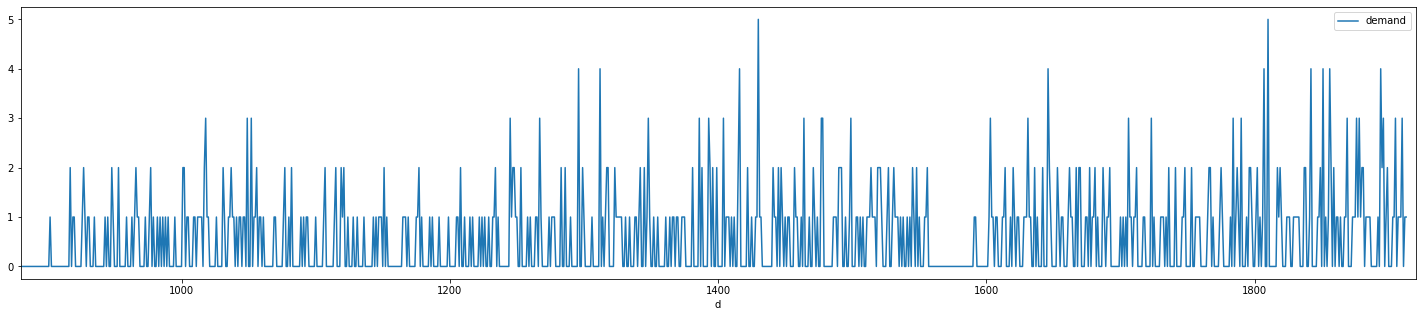

In [13]:
# sample_1[['d','demand']].plot.line(x='d', y='demand', figsize=(25, 5), xlim=(880,1920))

the mean (sum/max/min) of the intervals between non-zero values should be considered as the characteristic of a product (lifetime of the product)
* non-zero values can be changed to certain values, like the maximum

In [14]:
# sample_1[['d', 'demand']][sample_1['d']>880].to_csv('sample_1.csv', index=None)

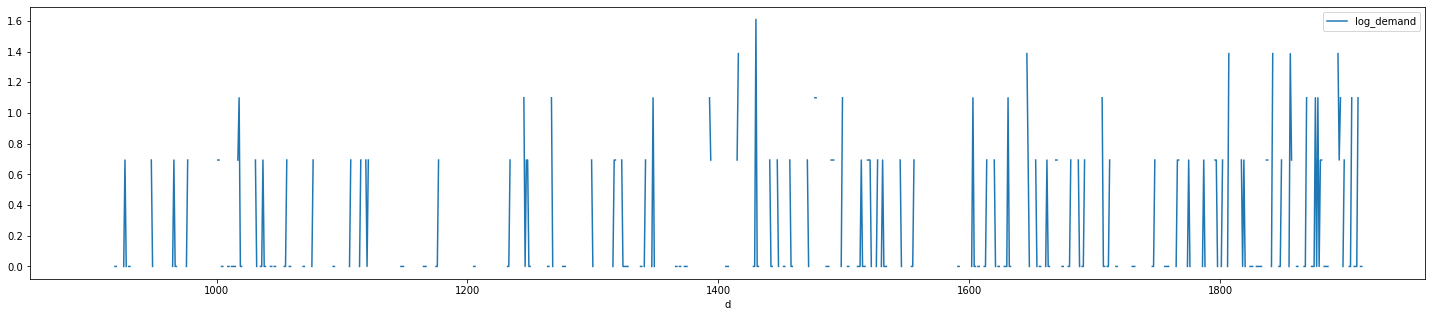

In [15]:
# sample_1['log_demand'] = np.log(sample_1['demand'])
# sample_1[['d', 'log_demand']].plot.line(x='d', y='log_demand', figsize=(25,5))

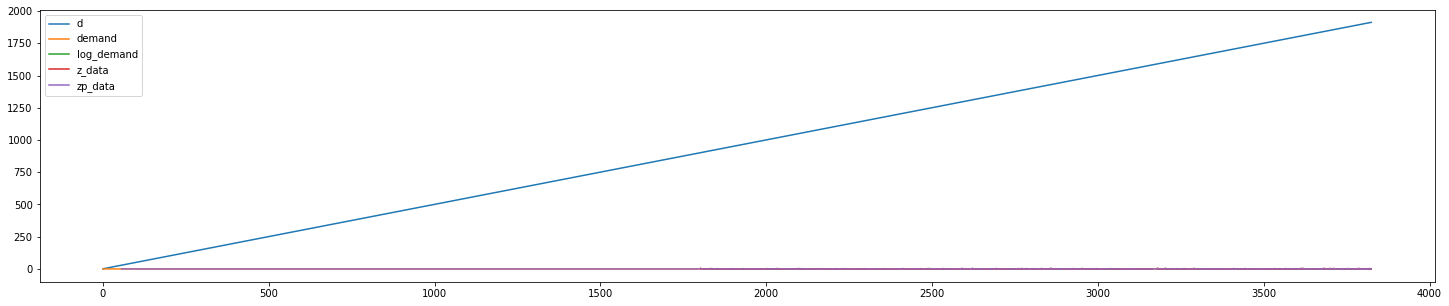

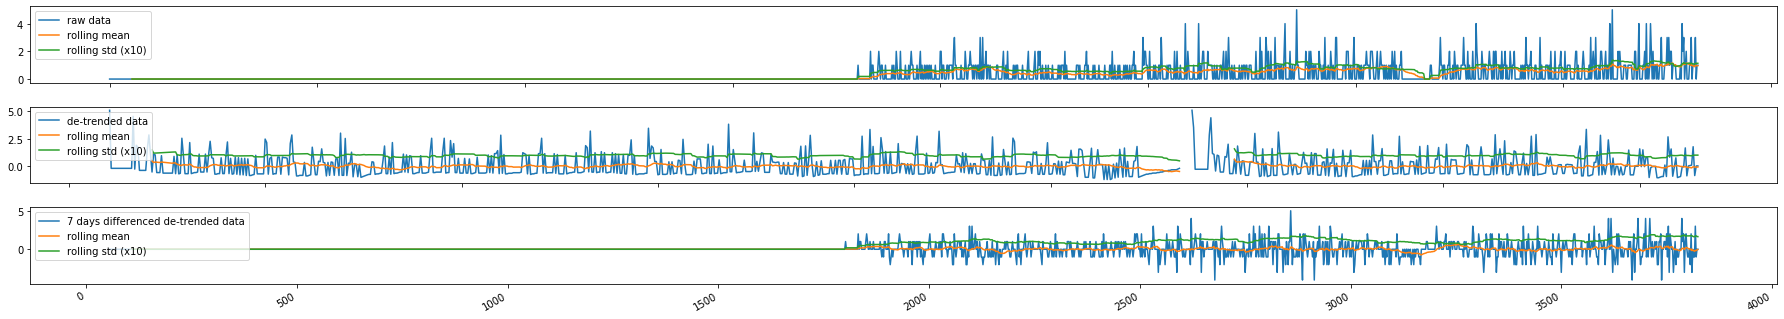

In [21]:
# plt.style.use('solarize_light2')
sample_1.plot(figsize=(25,5))
# window_size will be set as 28 days
sample_1['z_data'] = (sample_1['demand'] - sample_1.demand.rolling(window=28).mean()) / sample_1.demand.rolling(window=28).std()  # sharpe ratio
# get the difference between each value and mean
sample_1['zp_data'] = sample_1['demand'] - sample_1['demand'].shift(28)
# compare with the performance last 28 days (a month)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(25, 5))
    ax[0].plot(df.index, df.demand, label='raw data')
    ax[0].plot(df.demand.rolling(window=28).mean(), label="rolling mean");
    ax[0].plot(df.demand.rolling(window=28).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=28).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=28).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="28 days differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=28).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=28).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
plot_rolling(sample_1)

so our data is actually stationary

### Augmented Dickey-Fuller Test

This test is used to assess whether or not a time-series is stationary. Without getting into too much details about hypothesis testing, you should know that this test will give a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not.

In [23]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(sample_1.demand, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(sample_1.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(sample_1.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -2.118
P-value = 0.237
Critical values :
	1%: -3.433814658052138 - The data is not stationary with 99% confidence
	5%: -2.8630704504871605 - The data is not stationary with 95% confidence
	10%: -2.56758475462613 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -17.631
P-value = 0.000
Critical values :
	1%: -3.4368995989062348 - The data is  stationary with 99% confidence
	5%: -2.8644316780522177 - The data is  stationary with 95% confidence
	10%: -2.568309666527279 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -6.065
P-value = 0.000
Critical values :
	1%: -3.433870617038361 - The data is  stationary with 99% confidence
	5%: -2.863095154794451 - The data is  stationary with 95% confidence
	10%: -2.567597908717771 - The data is  stationary with 90% confidence


we would better use test statistic to decide the data is stationary or not, because p-value is calcualted based on test statistic. If test statistic is less than critical values (the one behind :), the null hypothesis (there is a unit root => non-stationary) will be rejected to the X%. E.g. the 3rd test statistic (-6.065) is less the critical value in 1% (-3.433), meaning 99% area could be proven to reject the null hypothesis.

#### Autocorrelation plots (ACF & PACF)
the correlation between the raw data and the various time functions of it (lags).
序列数据自身，与在其上进行关于时间的函数变化之后得到的一段段函数之间是否存在相关。

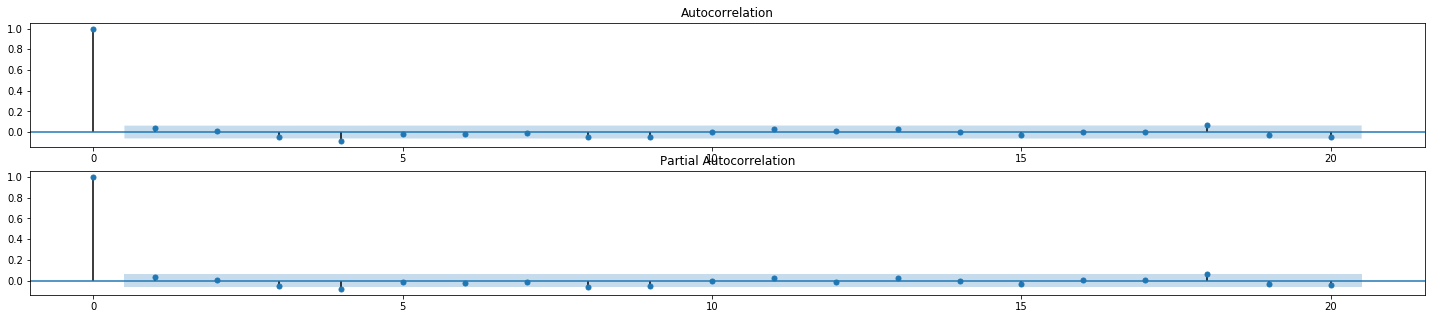

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize=(25,5))
ax[0] = plot_acf(sample_1.z_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(sample_1.z_data.dropna(), ax=ax[1], lags=20)

the first spikes is above the blue region, meaning there is correlations at lags 1, 2, 3 and 4.

#### Choosing a model
Exponential smoothings methods are appropriate for non-stationary data (ie data with a trend and seasonal data).

ARIMA models should be used on stationary data only. One should therefore remove the trend of the data (via deflating or logging), and then look at the differenced series.

#### Smoothing methods
Smoothing methods work as weighted averages. Forecasts are weighted averages of past
observations. The weights can be uniform (this is a moving average), or following an exponential decay -- more weight to recent observations and less weight to the old ones.

##### Simple Exponential Smoothing (SES)
when to use: Few data points, Irregular data, No seasonality or trend.
math behind: Just keep in mind that SES only has one component called level (with a smoothing parameter denoted as “alpha” below). It is a weighted average of the previous level and the current observation:

##### Holt's Linear Smoothing
when to use: trend in data, no seasonality
math behind: The forecast is made of a level component and a trend component.

In [37]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

train = sample_1.iloc[800:-100, :]
test = sample_1.iloc[-100:,:]
train.index = pd.to_datetime(train.index, unit='d') 
test.index = pd.to_datetime(test.index, unit='d')

In [38]:
train

,demand
d,
1972-03-12,0
1972-03-13,0
1972-03-14,0
1972-03-15,0
1972-03-16,0
...,...
1974-12-15,0
1974-12-16,5
1974-12-17,0


In [39]:
test

,demand
d,
1974-12-20,0
1974-12-21,0
1974-12-22,0
1974-12-23,2
1974-12-24,1
...,...
1975-03-25,1
1975-03-26,3
1975-03-27,0


In [40]:
pred = test['demand'].copy()

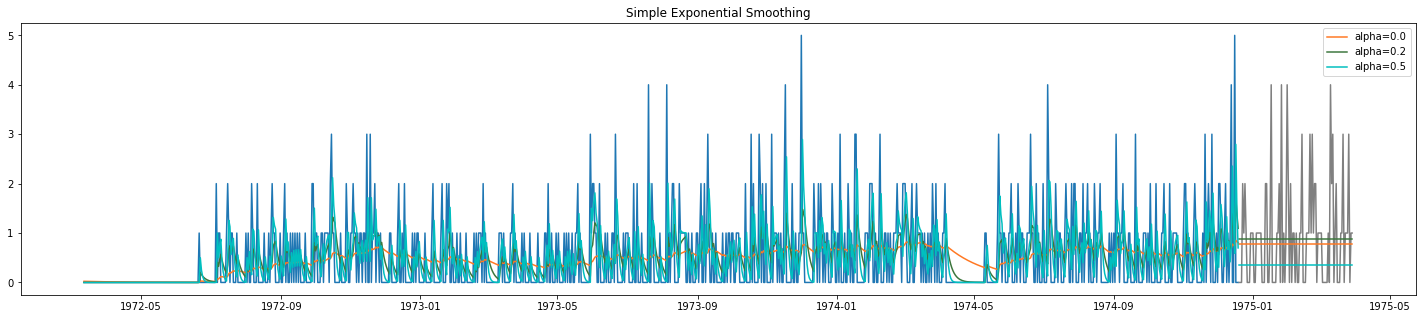

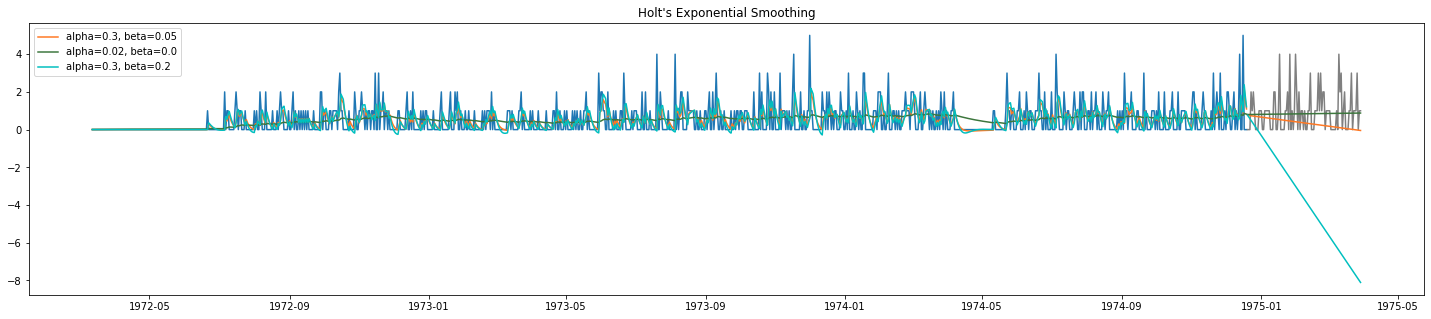

In [43]:
model = SimpleExpSmoothing(train)
# model._index = train.index  # pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(100)
# print(type(pred1), len(pred1))
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(100)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(100)

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(train.index, train.demand)
ax.plot(test.index, test.demand, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();
    
model = Holt(train)
# model._index = train.index # pd.to_datetime(train.index, unit='d')

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(100)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(100)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(100)

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(train.index, train.demand)
ax.plot(test.index, test.demand, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

from the above graphs, we can see the result with the setting "smoothing_level=.3, smoothing_slope=.2" (alpha=0.3, beta=0.2) mostly matches the real value but this experiment has the below limitation, which we could improve later,
* test set may be too small
* the subject is just one
* but we can see the strength of this type of models, these results from the models can be **directly considered as features**

#### Holt’s Damped Trend
The problem with Holt’s Linear trend method is that the trend is constant in the future,
increasing or decreasing indefinitely. For long forecast horizons, this can be problematic. The damped trend method is therefore a method which add a dampening parameter so that the trend converges to a constant value in the future (it flattens the trend). 

when to use: Data has a trend. Use the multiplicative version, unless the data has been logged before. In this case, use the additive version

In [44]:
print(train.head())
print(test.head())

            demand
d                 
1972-03-12       0
1972-03-13       0
1972-03-14       0
1972-03-15       0
1972-03-16       0
            demand
d                 
1974-12-20       0
1974-12-21       0
1974-12-22       0
1974-12-23       2
1974-12-24       1


In [48]:
train[train['demand'] == 0] = 0.000000001

In [67]:
train

,demand
d,
1972-03-12,1.000000e-09
1972-03-13,1.000000e-09
1972-03-14,1.000000e-09
1972-03-15,1.000000e-09
1972-03-16,1.000000e-09
...,...
1974-12-15,1.000000e-09
1974-12-16,5.000000e+00
1974-12-17,1.000000e-09


In [68]:
test

,demand
d,
1974-12-20,0
1974-12-21,0
1974-12-22,0
1974-12-23,2
1974-12-24,1
...,...
1975-03-25,1
1975-03-26,3
1975-03-27,0


In [78]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# model = ExponentialSmoothing(np.asarray(train['demand']), trend='mul', seasonal=None)
# model2 = ExponentialSmoothing(np.asarray(train['demand']), trend='mul', seasonal=None, damped=True)
# model._index = pd.to_datetime(train.index)
model = ExponentialSmoothing(train, trend='mul', seasonal=None)
model2 = ExponentialSmoothing(train, trend='mul', seasonal=None, damped=True)
# model._index = train.index

fit1 = model.fit()
fit2 = model2.fit()

In [79]:
type(fit1.fittedvalues)

pandas.core.series.Series

In [80]:
pred1 = fit1.forecast(100)
pred2 = fit2.forecast(100)

In [81]:
pred1 = pred1.fillna(0)
pred2 = pred2.fillna(0)

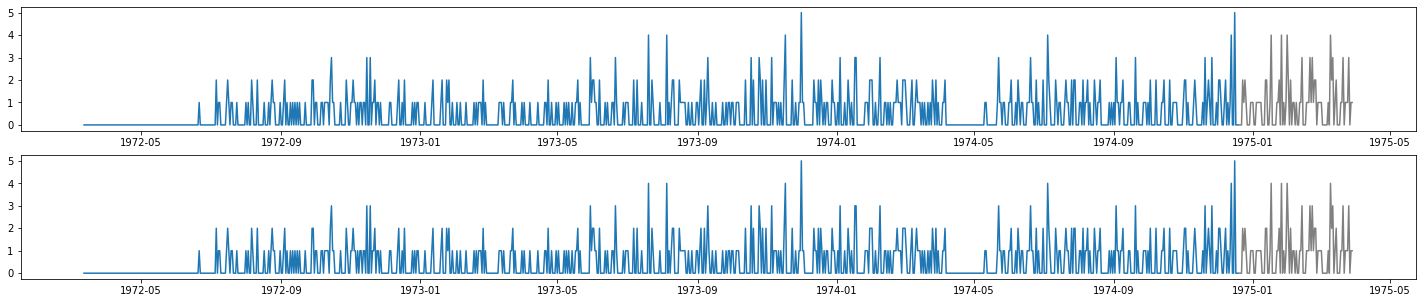

In [82]:
fig, ax = plt.subplots(2, figsize=(25, 5))
ax[0].plot(train.index, train.values)
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index, train.values)
ax[1].plot(test.index, test.values, color="gray", label="truth")

No handles with labels found to put in legend.


p
 0.0    100
dtype: int64
f
 0.000000e+00     861
1.000000e-09     101
inf                2
4.935822e+75       1
2.941133e+152      1
1.000000e-09       1
1.492482e+197      1
5.921167e+292      1
5.059292e+107      1
6.725736e+30       1
3.593976e+203      1
3.161906e+120      1
1.266548e+114      1
6.180709e+190      1
7.596867e+62       1
1.051193e+178      1
4.317154e+171      1
2.591473e+24       1
1.100530e+280      1
1.175419e+229      1
2.015362e+101      1
3.150604e+305      1
2.556272e+286      1
2.066776e+216      1
3.815457e+11       1
1.740717e+37       1
1.768105e+165      1
2.552482e+184      1
7.221271e+158      1
4.838407e+139      1
4.935662e+222      1
1.561372e+248      1
4.724896e+273      1
7.871753e+126      1
3.677350e+254      1
8.636918e+260      1
1.156354e+50       1
8.005930e+94       1
2.022916e+267      1
9.957469e+17       1
1.194568e+146      1
3.171507e+88       1
1.457939e+05       1
8.630513e+209      1
6.611092e+241      1
4.492745e+43       1
1.95

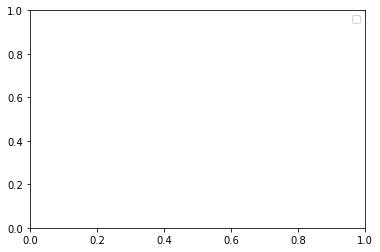

In [86]:
import math
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    f.fittedvalues = f.fittedvalues.fillna(0)
    ax[0].plot(train.index, f.fittedvalues, color=c)
    ax[1].plot(train.index, f.fittedvalues, color=c)

    d_slope = f.params['damping_slope']
    if math.isnan(d_slope):
        d_slope = -1
    print('p\n', p.value_counts())
    print('f\n', f.fittedvalues.value_counts())
#     ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if d_slope >0 else False), color=c)
#     ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if d_slope >0 else False), color=c)
    ax[0].plot(test.index, p, color=c)
    ax[1].plot(test.index, p, color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

this method may not be able to be applied to our data, since it refueses 0 and predict everything as 0.

#### ARIMA
ARIMA models (which include ARMA, AR and MA models) are a general class of models to forecast stationary time series. ARIMA models are made of three parts:
* A weighted sum of lagged values of the series (Auto-regressive (AR) part)
* A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part)
* A difference of the time series (Integrated (I) part)

##### Choosing the differencing order
The first step of fitting an ARIMA model is to determine the differencing order to stationarize the series. To do that, we look at the ACF and PACF plots, and keep in mind these two rules:
* If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.
* If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag- 1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.

In [8]:
# sample_1.to_csv('sample_1.csv', index=True, header=True)

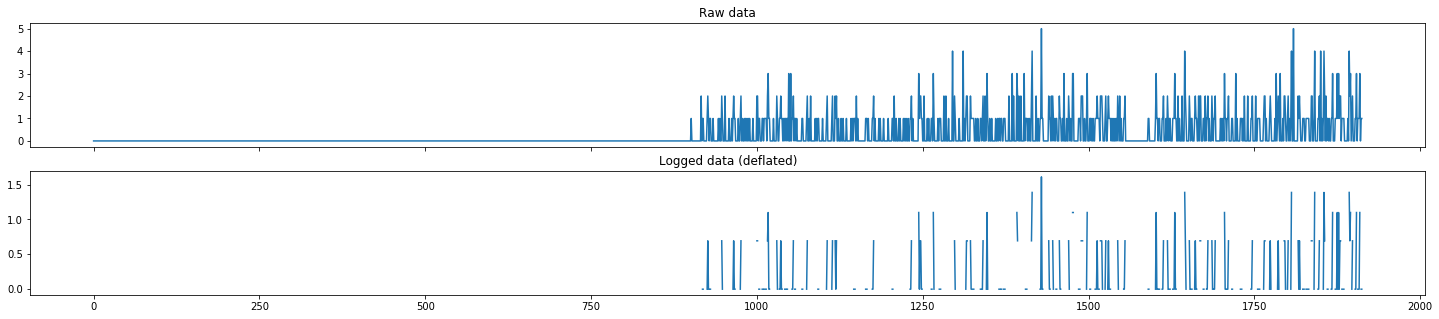

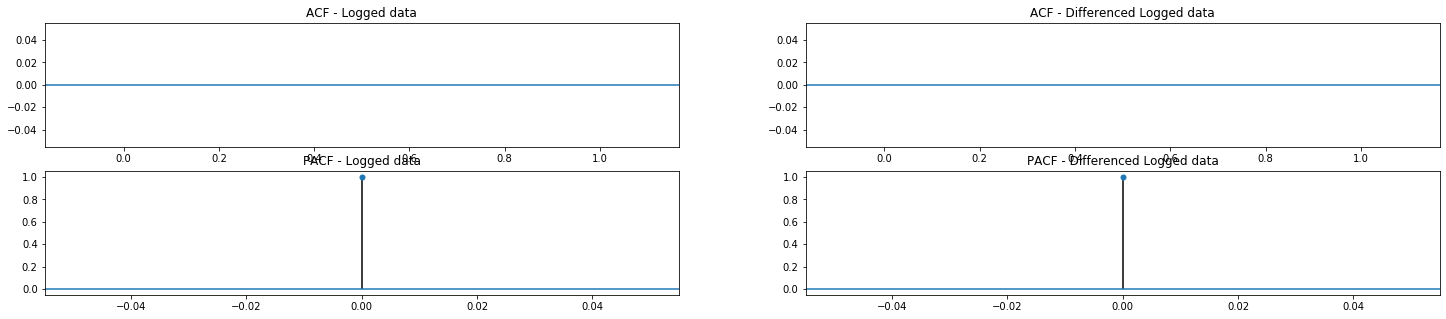

In [11]:
fig, ax = plt.subplots(2, sharex=True, figsize=(25, 5))
ax[0].plot(sample_1.demand.values);
ax[0].set_title("Raw data");
ax[1].plot(np.log(sample_1.demand.values));
ax[1].set_title("Logged data (deflated)");
# ax[1].set_ylim(0, 15);

fig, ax = plt.subplots(2, 2, figsize=(25, 5))
first_diff = (np.log(sample_1.demand)- np.log(sample_1.demand).shift()).dropna()
ax[0, 0] = plot_acf(np.log(sample_1.demand), ax=ax[0, 0], lags=20, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(sample_1.demand), ax=ax[1, 0], lags=20, title="PACF - Logged data")
print('\n')
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced Logged data")

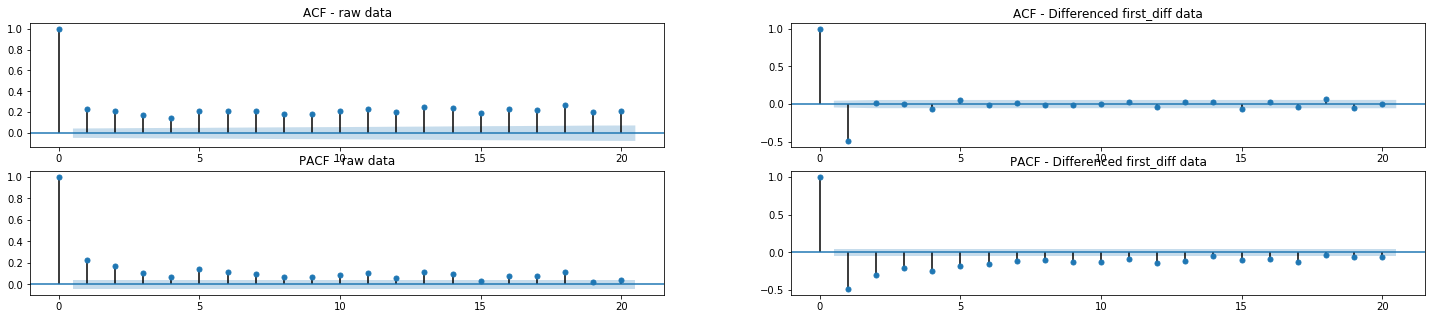

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(25, 5))
first_diff = ((sample_1.demand)- sample_1.demand.shift()).dropna()
ax[0, 0] = plot_acf(sample_1.demand, ax=ax[0, 0], lags=20, title="ACF - raw data")
ax[1, 0] = plot_pacf(sample_1.demand, ax=ax[1, 0], lags=20, title="PACF - raw data")

ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced first_diff data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced first_diff data")

ACF: stationary
* with consideration of direct and indirect effect on the current, e.g. the price of carrot in this month might be affected by the previous month and/or two months before, ACF considers both
* all values should stay around or in the blue area to show it's stationary.

PACF: how many lags matter
* show the direct effect from time t prior

from "ACF-differenced raw data", we can see it is non-stationary; the difference in lags of PACF is not obvious, so we can make a decision of the number of lags from it

In [14]:
df = pd.DataFrame({'a':[1,2,3]})
print(df)
print(df.shift())

   a
0  1
1  2
2  3
     a
0  NaN
1  1.0
2  2.0


In [15]:
df - df.shift()

,a
0,NaN
1,1.0
2,1.0
